In [58]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

### APPLICATIONS TABLE

In [63]:
app_train = pd.read_csv("Home_credits_loan/all/application_train.csv")

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [64]:
variables_type = pd.DataFrame(app_train.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in app_train:
    if (list(app_train[i].unique()) == [0,1]) or (list(app_train[i].unique()) == [1,0]):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Categorical variables (binary): ['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', '

#### Analyzing missing values

I think it doesn't make sense building a model on variables that have higher than 50% missing values (we have to substitute them by the median and actually infer values and having such a high % would imply that our predictions would lay on fabricated values)

In [21]:
miss_lower50 = []
miss_higher50 = []

for i in app_train:
    pct_missing = (app_train[i].isna().sum()/len(app_train[i]))*100
    if pct_missing > 0 and pct_missing < 50:
        miss_lower50.append(i)
    if pct_missing >= 50:
        miss_higher50.append(i)

In [22]:
#Excluding the variables with missing values higher or equal to 50%
cat_variables = [i for i in cat_variables if i not in miss_higher50]
cat_binary_variables = [i for i in cat_binary_variables if i not in miss_higher50]
num_variables = [i for i in num_variables if i not in miss_higher50]

#### Cleaning all remaining variables

##### Categorical variables

In [67]:
for i in cat_variables:
    print(i, app_train[i].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' 'XNA']
FLAG_OWN_CAR [0 1]
FLAG_OWN_REALTY [1 0]
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realt

In [66]:
#FLAG_OWN_CAR, FLAG_OWN_REALTY AND EMERGENCYSTATE_MODE ARE ALREADY BINARY VARIABLES CODIFIED IN A DIFFERENT WAY (YES/NO)
app_train["FLAG_OWN_CAR"] = app_train["FLAG_OWN_CAR"].apply(lambda x: 0 if x == 'N' else 1)
app_train["FLAG_OWN_REALTY"] = app_train["FLAG_OWN_REALTY"].apply(lambda x: 0 if x == 'N' else 1)
app_train["EMERGENCYSTATE_MODE"] = app_train["EMERGENCYSTATE_MODE"].apply(lambda x: 0 if x == 'No' else (1 if x == 'Yes' else x))

0         0.0
1         0.0
2         NaN
3         NaN
4         NaN
         ... 
307506    0.0
307507    0.0
307508    0.0
307509    0.0
307510    0.0
Name: EMERGENCYSTATE_MODE, Length: 307511, dtype: float64

In [ ]:
cat_variables = [i for i in cat_variables if i not in ["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"]]
cat_binary_variables.extend(["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"])

##### Numerical variables

In [44]:
app_train[num_variables].describe()

,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.417052,-16036.995067,63815.045904,-2994.202373,2.052463,2.031521,12.063419,1.687979e+05,5.990260e+05,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.722121,4363.988632,141275.766519,1509.450419,0.509034,0.502737,3.265832,2.371231e+05,4.024908e+05,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,1.000000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,19.000000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Findings:
- "DAYS(...)" variables are counter-intuitively negative
- "REGION_RATING_CLIENT(...)" should be consider categorical since they only have values 1, 2 and 3
- DAYS_EMPLOYED mean is 63815 (equivalent to around 174.8 years), so there should be outliers (wrongly inserted values) we need to look deeper at

In [ ]:
cat_variables.extend(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])
num_variables = [i for i in num_variables if i not in ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]

<AxesSubplot:>

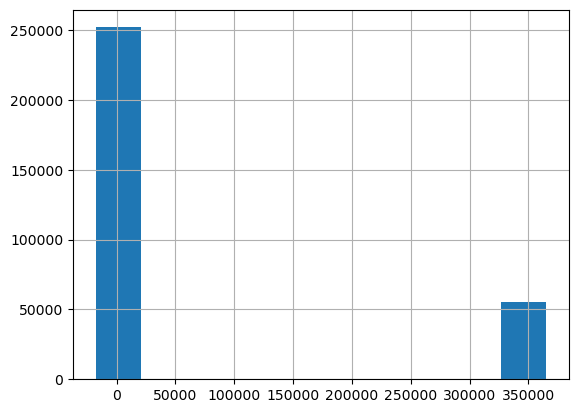

In [50]:
app_train["DAYS_EMPLOYED"].hist()

In [51]:
print(app_train[app_train["DAYS_EMPLOYED"] > 325000][["DAYS_EMPLOYED"]].value_counts())
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

DAYS_EMPLOYED
365243           55374
dtype: int64


In [52]:
#PUT DAY VARIABLES IN A LIST AND EXCLUDE THEM FROM THE NUMERICAL VALUES TO TRANSFORM THIS GROUP OF COLUMNS TOGETHER IN A PIPELINE
day_variables = [col for col in app_train.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]


#### Transformation Pipeline

In [17]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, bank, y=None):
        return self
    def transform(self, bank):
        return bank[self.attribute_names].values

In [ ]:
def negative_to_positive(columns):
    for i in columns:
        app_train[i] = abs(app_train[i])

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', negative_to_positive(day_variables)),
        ('selector', DataFrameSelector(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('selector', DataFrameSelector(cat_binary_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

In [24]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(20))
print('\nMost Negative Correlations:\n', correlations.head(20))   

Most Positive Correlations:
 OBS_60_CNT_SOCIAL_CIRCLE       0.009022
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.15